# Stochastic Analysis
### performance and time as a function of agents number, f (robots speed) and robots number

## load tables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
agents_number_df = pd.read_csv('./agents_results.csv')
agents_number_df = agents_number_df.drop_duplicates(subset='damage')
agents_number_df = agents_number_df.loc[(agents_number_df['d'] == 5) & (agents_number_df['sigma'] == 1)]
agents_number_df = agents_number_df.groupby(['planner', 'num_agents'], as_index=False).mean()
agents_number_df.head()

,planner,num_agents,num_robots,f,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticAdditive5LackPlanner,50,5.0,2.0,5.0,1.0,172.800799,6.033328,7673.417064,38.6335
1,StochasticAdditive5LackPlanner,100,5.0,2.0,5.0,1.0,171.090335,29.689702,17932.195877,59.7600
2,StochasticAdditive5LackPlanner,200,5.0,2.0,5.0,1.0,140.000000,5.790841,38463.280000,72.3920
3,StochasticAdditive5LackPlanner,300,5.0,2.0,5.0,1.0,140.000000,11.316855,58835.320000,101.0730
4,StochasticAdditive5LackPlanner,400,5.0,2.0,5.0,1.0,140.000000,13.054559,80961.000000,117.0500


In [10]:
f_df = pd.read_csv('./f_results.csv')
f_df = f_df.drop_duplicates(subset='damage')
f_df = agents_number_df.loc[(f_df['num_agents'] == 200)]
f_df = f_df.groupby(['planner', 'f', 'num_agents'], as_index=False).mean()
f_df.head()

,planner,f,num_agents,num_robots,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticAdditive5LackPlanner,2.0,50,5.0,5.0,1.0,172.800799,6.033328,7673.417064,38.6335
1,StochasticAdditive5LackPlanner,2.0,100,5.0,5.0,1.0,171.090335,29.689702,17932.195877,59.7600
2,StochasticAdditive5LackPlanner,2.0,200,5.0,5.0,1.0,140.000000,5.790841,38463.280000,72.3920
3,StochasticAdditive5LackPlanner,2.0,300,5.0,5.0,1.0,140.000000,11.316855,58835.320000,101.0730
4,StochasticAdditive5LackPlanner,2.0,400,5.0,5.0,1.0,140.000000,13.054559,80961.000000,117.0500


In [14]:
robots_df = pd.read_csv('./robots_results.csv')
robots_df = robots_df.drop_duplicates(subset=['planner', 'damage'])
robots_df = robots_df.groupby(['planner', 'num_robots', 'num_agents'], as_index=False).mean()
robots_df.head()

,planner,num_robots,num_agents


## visualizations

In [ ]:
planners_names = ['StochasticIterativePlanner', 'StochasticStaticLackPlanner', 'StochasticAdditive5LackPlanner',
                  'StochasticMonotone15LackPlanner', 'StochasticMonotone20LackPlanner',
                  'StochasticMonotone30LackPlanner', 'StochasticMonotone45LackPlanner']

colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:olive', 'tab:cyan', 'tab:purple', 'tab:pink']

In [16]:
agents_number_df = [agents_number_df.loc[agents_number_df['planner'] == name] for name in planners_names]

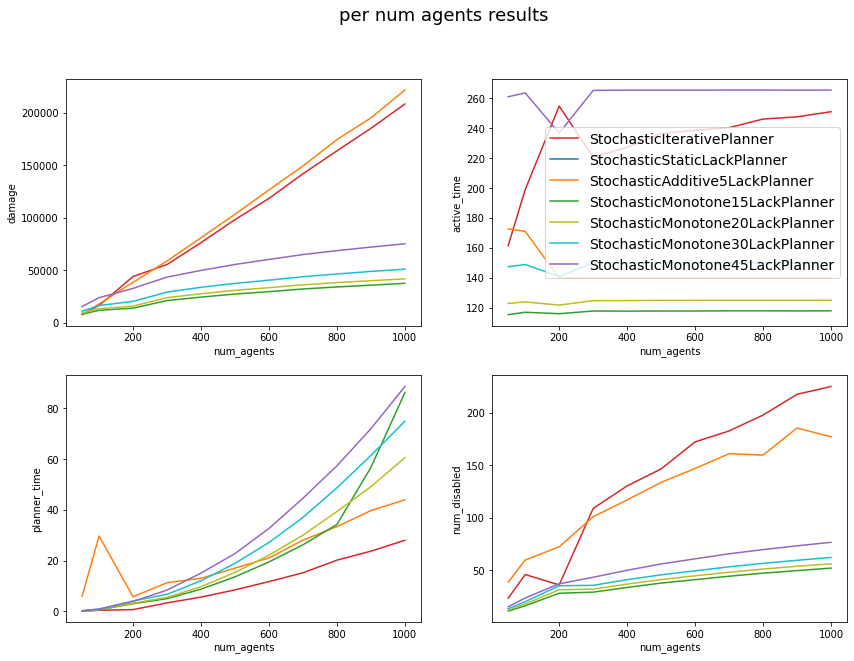

In [17]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['num_agents' for y in Y]

plt.figure(figsize=(14,10))
plt.suptitle('per num agents results', fontsize=18)

for i in range(len(Y)):
    x, y = X[i], Y[i]

    plt.subplot(2, 2, i+1)
    plt.xlabel(x)
    plt.ylabel(y)
    for j in range(len(agents_number_df)):
        r = agents_number_df[j]
        plt.plot(list(r[x]), list(r[y]), c=colors[j])

    if i==1:
        plt.legend(planners_names, fontsize='14')

plt.savefig('./plots/stochastic_num_agents.png')
plt.show()

In [ ]:
f_df = [f_df.loc[f_df['planner'] == name] for name in planners_names]

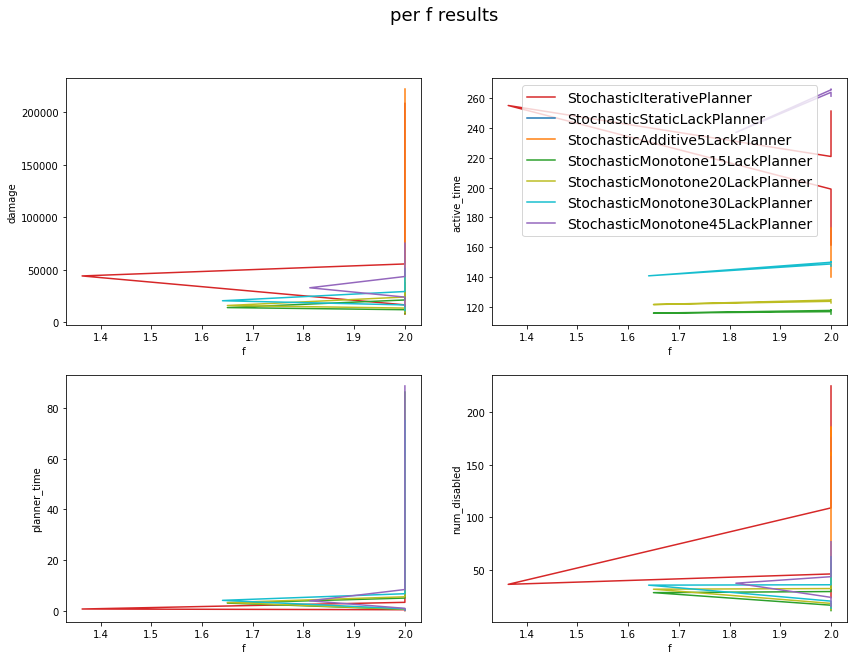

In [18]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['f' for y in Y]

plt.figure(figsize=(14,10))
plt.suptitle('per f results', fontsize=18)

for i in range(len(Y)):
    x, y = X[i], Y[i]

    plt.subplot(2, 2, i+1)
    plt.xlabel(x)
    plt.ylabel(y)
    for j in range(len(f_df)):
        r = f_df[j]
        plt.plot(list(r[x]), list(r[y]), c=colors[j])

    if i==1:
        plt.legend(planners_names, fontsize='14')

plt.savefig('./plots/stochastic_f.png')
plt.show()

In [ ]:
robots_df = [robots_df.loc[robots_df['planner'] == name] for name in planners_names]

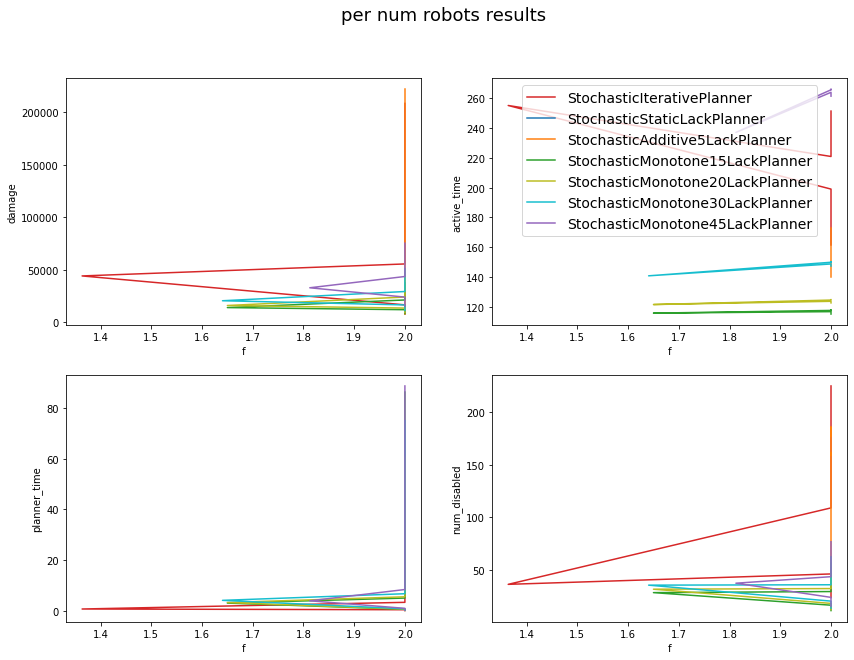

In [19]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['f' for y in Y]

plt.figure(figsize=(14,10))
plt.suptitle('per num robots results', fontsize=18)

for i in range(len(Y)):
    x, y = X[i], Y[i]

    plt.subplot(2, 2, i+1)
    plt.xlabel(x)
    plt.ylabel(y)
    for j in range(len(robots_df)):
        r = robots_df[j]
        plt.plot(list(r[x]), list(r[y]), c=colors[j])

    if i==1:
        plt.legend(planners_names, fontsize='14')

plt.savefig('./plots/stochastic_num_robots.png')
plt.show()

## run experiments

In [20]:
import json
import math
import time
from random import seed

from planners.stochastic.baseline.stochastic_iterative_planner import StochasticIterativePlanner
from planners.stochastic.partial_blockage.stochastic_additive_lack_planner import StochasticAdditiveLackPlanner
from planners.stochastic.partial_blockage.stochastic_monotone_lack_planner import StochasticMonotoneLackPlanner
from world.agents.stochastic_agent import StochasticAgent
from world.robots.timing_robot import TimingRobot
from world.stochastic_environment import StochasticEnvironment
from planners.planner import Planner
from planners.stochastic.partial_blockage.stochastic_static_lack_planner import StochasticStaticLackPlanner
from utils.functions import *

with open('config.json') as json_file:
    config = json.load(json_file)


def run(planner: Planner, file_name: str):
    agents = [StochasticAgent(loc=sample_point(config['x_buffer'], config['x_buffer'] + config['x_size'],
                                               config['y_buffer'], config['y_buffer'] + config['y_size_init'], True),
                              v=config['agent_speed'],
                              sigma=config['sigma']) for _ in
              range(config['num_agents'])]

    robots = [BasicRobot(sample_point(0, config['x_size'] + 2 * config['x_buffer'], 0, config['y_buffer'], True),
                         config['robot_speed'], config['disablement_range']) for _ in range(config['num_robots'])]

    env = StochasticEnvironment(agents=agents, robots=robots, top_border=config['y_size'] + config['y_buffer'],
                                right_border=config['x_size'] + config['x_buffer'], left_border=config['x_buffer'])

    before = time.time()
    _, active_time, expected_damage, expected_num_disabled = planner.plan(env)
    planning_time = time.time() - before

    write_report(planner=str(planner),
                 num_agents=config['num_agents'],
                 num_robots=config['num_robots'],
                 f=config['robot_speed'] / config['agent_speed'],
                 d=config['disablement_range'],
                 active_or_copmletion_time=active_time,
                 planner_time=planning_time,
                 damage=expected_damage,
                 num_disabled=expected_num_disabled,
                 file_name=file_name,
                 is_active_time=True,
                 sigma=config['sigma'])

In [21]:
planners = [StochasticMonotoneLackPlanner(), StochasticIterativePlanner(), StochasticStaticLackPlanner(),
            StochasticAdditiveLackPlanner()]

for planner in planners:
    for v in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
        print(f'*** *** v={v} *** ***')
        for s in range(30):
            seed(s)

            config['num_agents'] = v
            print(f'running {str(planner)} with seed {s}..')
            run(planner, 'agents_results.csv')

*** *** v=50 *** ***
running StochasticMonotone22LackPlanner with seed 0..
running StochasticMonotone22LackPlanner with seed 1..
running StochasticMonotone22LackPlanner with seed 2..
running StochasticMonotone22LackPlanner with seed 3..
running StochasticMonotone22LackPlanner with seed 4..
running StochasticMonotone22LackPlanner with seed 5..
running StochasticMonotone22LackPlanner with seed 6..
running StochasticMonotone22LackPlanner with seed 7..
running StochasticMonotone22LackPlanner with seed 8..
running StochasticMonotone22LackPlanner with seed 9..
running StochasticMonotone22LackPlanner with seed 10..
running StochasticMonotone22LackPlanner with seed 11..
running StochasticMonotone22LackPlanner with seed 12..
running StochasticMonotone22LackPlanner with seed 13..
running StochasticMonotone22LackPlanner with seed 14..
running StochasticMonotone22LackPlanner with seed 15..
running StochasticMonotone22LackPlanner with seed 16..
running StochasticMonotone22LackPlanner with seed 17..

KeyboardInterrupt: 

In [22]:
planners = [StochasticMonotoneLackPlanner(), StochasticIterativePlanner()]

config['num_agents'] = 300

for planner in planners:
    for alpha in [math.pi / 4, math.pi / 6, math.pi / 9, math.pi / 12]:
        planner.alpha = alpha
        for v in [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]:
            print(f'*** *** v={v} *** ***')
            for s in range(10):
                seed(s)

                config['robot_speed'] = v
                print(f'running {str(planner)} with seed {s}..')
                try:
                    run(planner, 'f_results.csv')
                except:
                    pass

*** *** v=1.2 *** ***
running StochasticMonotone45LackPlanner with seed 0..
running StochasticMonotone45LackPlanner with seed 1..
running StochasticMonotone45LackPlanner with seed 2..
running StochasticMonotone45LackPlanner with seed 3..
running StochasticMonotone45LackPlanner with seed 4..
running StochasticMonotone45LackPlanner with seed 5..
running StochasticMonotone45LackPlanner with seed 6..
running StochasticMonotone45LackPlanner with seed 7..
running StochasticMonotone45LackPlanner with seed 8..
running StochasticMonotone45LackPlanner with seed 9..
*** *** v=1.3 *** ***
running StochasticMonotone45LackPlanner with seed 0..
running StochasticMonotone45LackPlanner with seed 1..
running StochasticMonotone45LackPlanner with seed 2..
running StochasticMonotone45LackPlanner with seed 3..
running StochasticMonotone45LackPlanner with seed 4..
running StochasticMonotone45LackPlanner with seed 5..
running StochasticMonotone45LackPlanner with seed 6..
running StochasticMonotone45LackPlanne

In [23]:
planners = [StochasticMonotoneLackPlanner(), StochasticIterativePlanner()]

for planner in planners:
    for alpha in [math.pi / 4, math.pi / 6, math.pi / 9, math.pi / 12]:
        planner.alpha = alpha

        for v in [2, 3, 4, 5, 6, 7, 8]:
            print(f'*** *** v={v} *** ***')
            for s in range(10):
                seed(s)

                config['num_robots'] = v
                print(f'running {str(planner)} with seed {s}..')
                run(planner, 'robots_results.csv')

*** *** v=2 *** ***
running StochasticMonotone45LackPlanner with seed 0..
running StochasticMonotone45LackPlanner with seed 1..
running StochasticMonotone45LackPlanner with seed 2..
running StochasticMonotone45LackPlanner with seed 3..
running StochasticMonotone45LackPlanner with seed 4..
running StochasticMonotone45LackPlanner with seed 5..
running StochasticMonotone45LackPlanner with seed 6..
running StochasticMonotone45LackPlanner with seed 7..
running StochasticMonotone45LackPlanner with seed 8..
running StochasticMonotone45LackPlanner with seed 9..
*** *** v=3 *** ***
running StochasticMonotone45LackPlanner with seed 0..
running StochasticMonotone45LackPlanner with seed 1..
running StochasticMonotone45LackPlanner with seed 2..
running StochasticMonotone45LackPlanner with seed 3..
running StochasticMonotone45LackPlanner with seed 4..
running StochasticMonotone45LackPlanner with seed 5..
running StochasticMonotone45LackPlanner with seed 6..
running StochasticMonotone45LackPlanner wi

KeyboardInterrupt: 